<a href="https://colab.research.google.com/github/habeeb0502/habeeb0502/blob/main/Sentiment_Classification_Amazon_Product_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification on Amazon Product Reviews Using Bert, SVM and Random Forest

## 1. Introduction

### Objective:
The objective of this notebook is to leverage a **pre-trained BERT model** and the traditional Naive Bayes Model for the task of **supervised sentiment classification**.Specifically, we aim to classify Amazon product reviews into sentiment categories (e.g., negative, neutral, or positive) based on their textual content. By capturing the nuanced language in customer feedback, this approach helps businesses and researchers gain more accurate insights into product reception and user satisfaction.

In addition, this notebook will compare the two approaches in supervised sentiment classification of the amazon reviews data set:

1. A **Random Forest and SVM** classifier, representing a traditional machine‐learning‐based approach.  
2. A **BERT**‐based model, leveraging state‐of‐the‐art deep learning techniques.
3. A **Weighted-BERT** model, for fine-tuning of basic BERT model for improvemnt.

### Problem Statement:
Nowadays, people rely heavily on online reviews before purchasing a product. Because each item can have countless reviews, it’s impractical for companies or consumers to manually process them all. Existing machine-based solutions often fall short in capturing emotional context and subtle linguistic cues, resulting in incomplete or inaccurate sentiment analysis. Consequently, there is a need for more advanced methods—like **BERT**—that can handle complex language patterns and reveal deeper insights into customer opinions.

### Dataset Description:
The dataset contains a list of amazon product reviews with the following important columns:

- **reviews.rating**: A numerical star rating indicating how the reviewer scored the product.
- **reviews.text**: The main body of the review, describing the customer’s experience and opinions.
- **reviews.title**: A brief title or headline for the review.
- **reviews.date**: The date when the review was posted.
- **reviews.numHelpful**: The number of “helpful” votes or acknowledgments from other users.
- **reviews.username**: The username of the reviewer.
- **name**: The product name associated with the review.

To perform supervised sentiment analysis, we map star ratings to **sentiment labels** (e.g., 1–2 as negative, 3 as neutral, 4–5 as positive). Both the Naive Bayes and BERT models will then learn to classify reviews into these sentiment categories based on the text.

In subsequent sections, we will describe our **data cleaning** process, the steps to **map ratings to sentiment**, and how we **train, evaluate, and compare** Random Forest, SVM, and BERT classifiers on this Amazon reviews dataset.

The dataset used in this notebook contains patent abstracts. It can be downloaded from [Amazon_product_Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews?resource=download).

In [ ]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


### 1. Install Required Libraries:

We'll install and import the necessary libraries for our analysis,

In [ ]:
import pandas as pd
import re
import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import plotly.express as px
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Data Loading and Exploration

**Load the dataset**

In [ ]:
file_path = "amazon_data.csv"  # Change this if using a different file path
df = pd.read_csv(file_path)

**Preview of Raw Dataset**

In [ ]:
print("First 5 rows of the raw Amazon Reviews dataset:")
display(df.head(5))

First 5 rows of the raw Amazon Reviews dataset:


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


## 3. Visualize the Raw Star Ratings



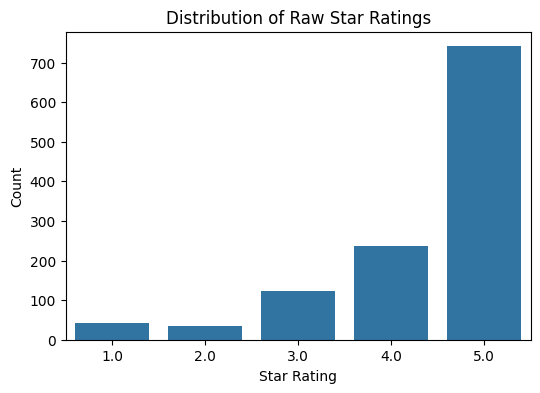

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='reviews.rating', data=df)
plt.title('Distribution of Raw Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

## 4. Cleaning the Review Text

In [ ]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))             # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)                # Remove punctuation
    text = text.lower()                                # Lowercase
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split()
                    if word not in stop_words)         # Remove stopwords
    return text

df['cleaned_review'] = df['reviews.text'].apply(clean_text)

In [ ]:
# Quick look at the original vs. cleaned text
print("Original vs. Cleaned Review (first 5 rows):")
display(df[['reviews.text','cleaned_review']].head(5))

Original vs. Cleaned Review (first 5 rows):


,reviews.text,cleaned_review
0,I initially had trouble deciding between the p...,initially trouble deciding paperwhite voyage r...
1,Allow me to preface this with a little history...,allow preface little history casual reader own...
2,I am enjoying it so far. Great for reading. Ha...,enjoying far great reading original fire since...
3,I bought one of the first Paperwhites and have...,bought one first paperwhites pleased constant ...
4,I have to say upfront - I don't like coroporat...,say upfront dont like coroporate hermetically ...


## 5. Word Cloud of the `'cleaned_review'`

The word cloud now reflects the cleaned version of the dataset and we can now see more clear and  more meaningful words.

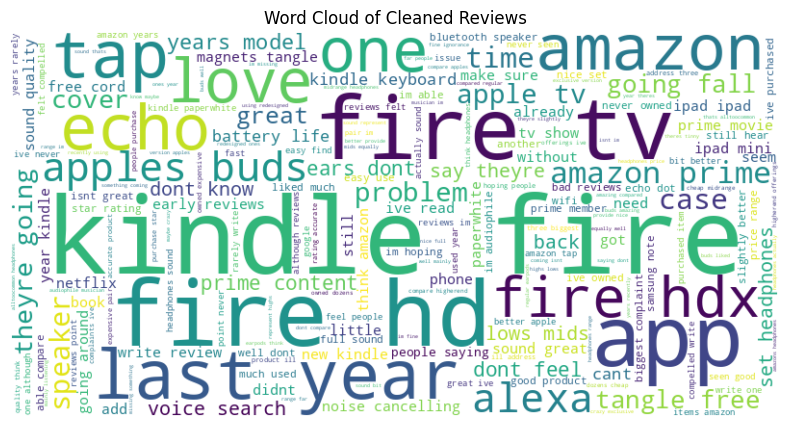

In [ ]:
cleaned_text = " ".join(str(review) for review in df["cleaned_review"])
wordcloud_cleaned = WordCloud(width=800, height=400, background_color="white").generate(cleaned_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_cleaned, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Cleaned Reviews")
plt.show()

## 6. Mapping `'rating'` column to Sentiment

In [ ]:
def rating_to_sentiment(rating):
    # Convert rating to numeric
    rating = pd.to_numeric(rating, errors='coerce')
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
df['reviews.rating'].fillna(3, inplace=True)  # default to neutral if missing
df['sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)

<ipython-input-9-f2e53c5b4c80>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.rating'].fillna(3, inplace=True)  # default to neutral if missing


**Visualize the new Sentiment labels**

The aim of this visualization is to show the distribution of the new sentiment labels (0-1-2)

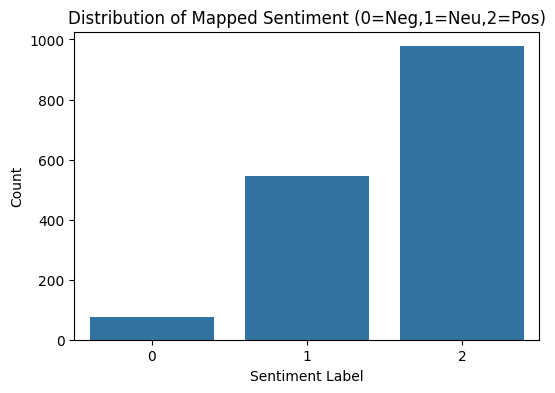

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Mapped Sentiment (0=Neg,1=Neu,2=Pos)')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

## 7. Word Cloud per Sentiment Category

The aim of this visualization is to illustrate how language differs in each sentiment category **negative**, **positive** and **neutral** reviews

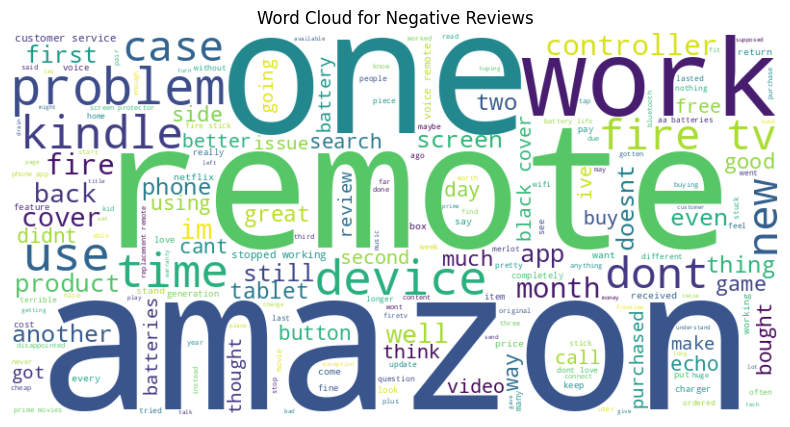

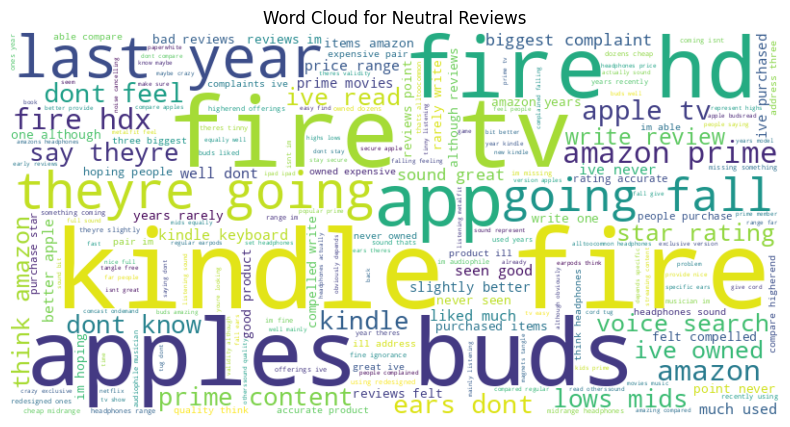

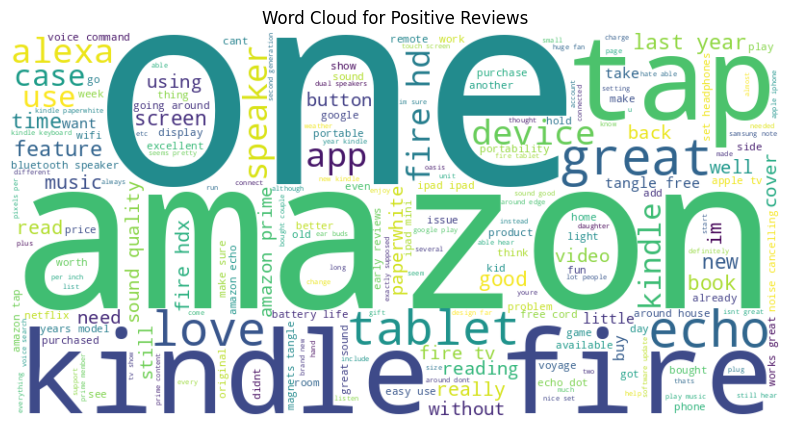

In [ ]:
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

for value, label in sentiment_mapping.items():
    subset = df[df['sentiment'] == value]
    text_for_wordcloud = " ".join(str(review) for review in subset['cleaned_review'])

    if text_for_wordcloud.strip():  # if there's actual text
        wordcloud_sent = WordCloud(width=800, height=400, background_color="white").generate(text_for_wordcloud)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_sent, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {label} Reviews")
        plt.show()
    else:
        print(f"No cleaned text found for {label} sentiment.")

## 8. Time-Based Sentiment Visualization

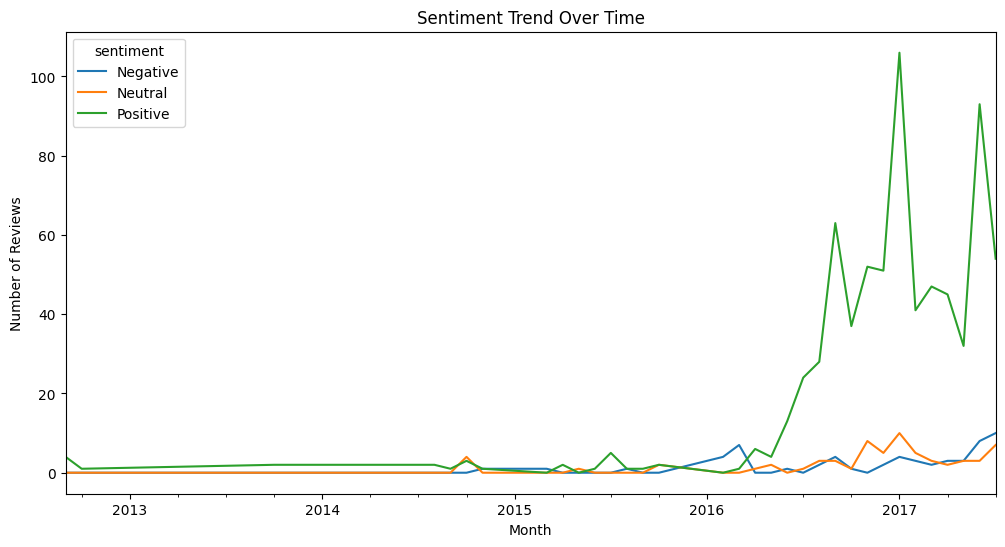

In [ ]:
# Time-Based Sentiment Analysis
df['reviews.date'] = pd.to_datetime(df['reviews.date'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')
df['month'] = df['reviews.date'].dt.to_period('M')
sentiment_over_time = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

#Visualization of sentiment trends over time
# Define sentiment mapping
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Rename the sentiment labels in the legend
sentiment_over_time.rename(columns=sentiment_mapping, inplace=True)

# Plot the sentiment trend over time
sentiment_over_time.plot(kind="line", figsize=(12, 6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()
#0 = negative
#1 = neutral
#2 = positive

## 9. Data Selection & Feature Engineering.

Note: We use feature engineering to derive insights for fake Review Detection

In [ ]:
# perform data selection
df = df[['reviews.text', 'reviews.title', 'reviews.rating', 'reviews.numHelpful', 'reviews.date', 'reviews.username', 'cleaned_review', 'sentiment']]
df.fillna('', inplace=True)

# Convert necessary columns to numeric
df['reviews.numHelpful'] = pd.to_numeric(df['reviews.numHelpful'], errors='coerce').fillna(0).astype(int)

# Create a 'review_length' column to store word counts
df['review_length'] = df['reviews.text'].apply(lambda x: len(str(x).split()))

<ipython-input-13-94496c13e8b2>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)
<ipython-input-13-94496c13e8b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna('', inplace=True)
<ipython-input-13-94496c13e8b2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews.numHelpful'] = pd.to_numeric(df['reviews.numHelpful'], errors='coerce').fillna(0).

##10. Fake Review Detection and Visualization

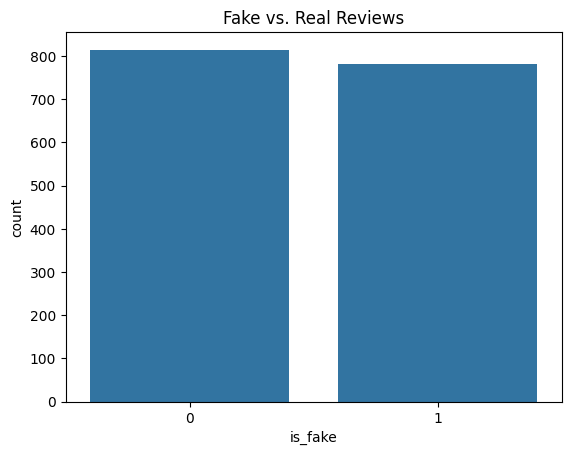

In [ ]:
#Fake Reviw criteria: short review, low helpful score, new user

df['is_short_review'] = df['review_length'].apply(lambda x: 1 if x < 10 else 0)
df['low_helpful_score'] = df['reviews.numHelpful'].apply(lambda x: 1 if x < 5 else 0)
df['new_user'] = df['reviews.username'].apply(
    lambda x: 1 if df['reviews.username'].value_counts().get(x, 0) < 3 else 0
)

# Mark as fake if at least two criteria are met
df['is_fake'] = df[['is_short_review', 'low_helpful_score', 'new_user']].sum(axis=1).apply(lambda x: 1 if x >= 2 else 0)

# Visualize the fake vs. real reviews
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_fake', data=df)
plt.title("Fake vs. Real Reviews")
plt.show()

# 11. Train-test-Split Count-Vectorizer,TF-IDF, SVM and Random Forest

We only use the columns `'cleaned_review`' and `'sentiment' `because Bert fundamentally only expects texts input and a classification sentiment label so other extra numerical features do not directly fit into Bert's token-based input.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( df['cleaned_review'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42 )

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pickle
from sklearn.metrics import classification_report, confusion_matrix

vectorizer_ml = CountVectorizer(stop_words='english')
X_vec_ml = vectorizer_ml.fit_transform(X_train)
tfidf_ml = TfidfTransformer()
X_train_tfidf_ml = tfidf_ml.fit_transform(X_vec_ml)

X_test_vec_ml = vectorizer_ml.transform(X_test)
X_test_tfidf_ml = tfidf_ml.transform(X_test_vec_ml)

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_tfidf_ml, y_train)
y_pred_rf = rf_clf.predict(X_test_tfidf_ml)
print("\nRandom Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.64      0.64      0.64       107
           2       0.78      0.81      0.80       202

    accuracy                           0.73       320
   macro avg       0.69      0.54      0.57       320
weighted avg       0.73      0.73      0.72       320

Confusion Matrix for Random Forest:
[[  2   1   8]
 [  1  68  38]
 [  0  38 164]]


In [ ]:
# SVM
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_tfidf_ml, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf_ml)
print("\nSVM Classifier Report:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix for SVM:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Classifier Report:
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        11
           1       0.60      0.69      0.64       107
           2       0.81      0.77      0.79       202

    accuracy                           0.72       320
   macro avg       0.64      0.58      0.60       320
weighted avg       0.73      0.72      0.73       320

Confusion Matrix for SVM:
[[  3   4   4]
 [  1  74  32]
 [  2  45 155]]


## 12. BERT Tokenization & Dataset Setup

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 13. Model Initialization & Training

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_steps=10_000,
    weight_decay=0.01,
    fp16=True,  # Enables mixed-precision training
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: charleswibo (charleswibo-georgia-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.597166
2,No log,0.621491
3,No log,0.677168


TrainOutput(global_step=480, training_loss=0.5466121037801107, metrics={'train_runtime': 100.5811, 'train_samples_per_second': 38.089, 'train_steps_per_second': 4.772, 'total_flos': 251996875828992.0, 'train_loss': 0.5466121037801107, 'epoch': 3.0})

## 14. DEMO Test

In [ ]:
#Predict Sentiment: positive
review_text = "This product is amazing! I love it."
encoded_input = tokenizer.encode_plus(review_text, return_tensors='pt', max_length=128, truncation=True, padding='max_length')
encoded_input = {k: v.cuda() for k, v in encoded_input.items()} # Move tensors to GPU
output = model(**encoded_input)
sentiment_label = torch.argmax(output.logits, dim=1).item()
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

print(f"Predicted Sentiment: {sentiment_mapping[sentiment_label]}")

#Predict Sentiment: negative
review_text = "This product is terrible! I hate it."
encoded_input = tokenizer.encode_plus(review_text, return_tensors='pt', max_length=128, truncation=True, padding='max_length')
encoded_input = {k: v.cuda() for k, v in encoded_input.items()} # Move tensors to GPU
output = model(**encoded_input)
sentiment_label = torch.argmax(output.logits, dim=1).item()
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

print(f"Predicted Sentiment: {sentiment_mapping[sentiment_label]}")

Predicted Sentiment: Positive
Predicted Sentiment: Negative


In [ ]:
import pandas as pd
import random
import torch

# Load dataset (modify the path if necessary)
#df = pd.read_csv("amazon_data.csv")

# Ensure dataset has the necessary columns
if "reviews.text" not in df.columns:
    raise ValueError("Dataset does not contain a 'review' column.")

# Select a random review from the dataset
random_review = df.sample(1)  # Pick a random row
review_text = random_review["reviews.text"].values[0]  # Extract review text

# Display the randomly selected review
print("\nRandomly Selected Review:")
print(review_text)

# Tokenize and encode the selected review for BERT
encoded_input = tokenizer.encode_plus(
    review_text, return_tensors="pt", max_length=128, truncation=True, padding="max_length"
)

# Move tensors to GPU if available
encoded_input = {k: v.cuda() for k, v in encoded_input.items()}

# Get model output
output = model(**encoded_input)

# Determine sentiment label
sentiment_label = torch.argmax(output.logits, dim=1).item()

# Mapping of model output to sentiment labels
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Display predicted sentiment
print(f"\nPredicted Sentiment: {sentiment_mapping[sentiment_label]}")




Randomly Selected Review:
I love this handheld device especially all the items available for it. Games, books, music, etc. Glad I bought it. Thanks for having it available.

Predicted Sentiment: Positive


In [ ]:
print(df.columns)

Index(['reviews.text', 'reviews.title', 'reviews.rating', 'reviews.numHelpful',
       'reviews.date', 'reviews.username', 'cleaned_review', 'sentiment',
       'review_length', 'is_short_review', 'low_helpful_score', 'new_user',
       'is_fake'],
      dtype='object')


## 15. BERT-Model Train/Test & Evaluation with Heatmap Visulization

In [ ]:
import torch

# Define device (Use GPU if available, else use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Tokenize X_test properly
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")

# Move tokenized input to the same device as the model
X_test_tensor = X_test_tokenized["input_ids"].to(device)

# Put model in evaluation mode
model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    outputs = model(X_test_tensor)  # Forward pass

# Extract logits (raw model outputs before softmax)
logits = outputs.logits

# Convert logits to class probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get the predicted class (argmax selects the class with the highest probability)
y_pred = torch.argmax(probabilities, dim=1).cpu().numpy()

print("Predictions:", y_pred)

Using device: cuda


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Predictions: [2 1 2 2 2 2 1 2 2 1 2 1 1 2 2 2 1 2 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 1 1 2 1 2 2 2 1 1 2 2 1 1 2 1 2 2 2
 1 2 1 2 2 2 2 2 2 2 2 1 2 1 1 2 2 1 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2 1 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2
 2 2 2 2 1 1 2 1 2 1 2 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 2 2 2 2 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2
 2 2 2 1 2 1 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.70
Precision: 0.66
Recall: 0.70
F1-Score: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.64      0.44      0.52       107
           2       0.72      0.87      0.79       202

    accuracy                           0.70       320
   macro avg       0.45      0.44      0.44       320
weighted avg       0.66      0.70      0.67       320



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

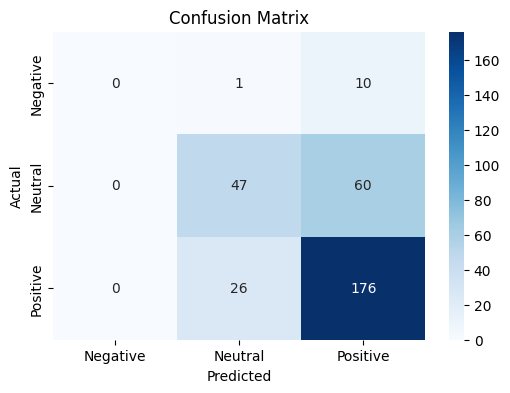

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 16. Adding Class Weighting

In [ ]:
print(df.columns)
print(df["reviews.rating"].unique())

Index(['reviews.text', 'reviews.title', 'reviews.rating', 'reviews.numHelpful',
       'reviews.date', 'reviews.username', 'cleaned_review', 'sentiment',
       'review_length', 'is_short_review', 'low_helpful_score', 'new_user',
       'is_fake'],
      dtype='object')
[5. 4. 3. 1. 2.]


In [ ]:
# Load your dataset (replace with actual file path)
df = pd.read_csv("amazon_data.csv")

# Convert numerical ratings to sentiment labels
def rating_to_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

# Apply the function to create sentiment labels
df["sentiment_label"] = df["reviews.rating"].apply(rating_to_sentiment)

# Map sentiment labels to numerical values
sentiment_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["sentiment"] = df["sentiment_label"].map(sentiment_mapping)

# Ensure all values are integers and handle missing values
df["sentiment"] = df["sentiment"].fillna(1).astype(int)  # Default NaN to Neutral

# Check class distribution
print(df["sentiment"].value_counts())

sentiment
2    977
0    496
1    124
Name: count, dtype: int64


In [ ]:
# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the reviews
tokens = tokenizer(df["reviews.text"].tolist(),
                   padding=True,
                   truncation=True,
                   max_length=128,
                   return_tensors="pt")

In [ ]:
# Extract unique sentiment labels from the dataset
classes = np.unique(df["sentiment"].values)  # Ensure all present labels are included

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=df["sentiment"].values)


# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

boost_factor = 5  # Increase weight impact
class_weights = class_weights * boost_factor

# Apply weighted CrossEntropyLoss
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

print("Class Weights:", class_weights)


Class Weights: tensor([ 5.3663, 21.4651,  2.7243], device='cuda:0')


**Training Weighted BERT-Model**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tokens["input_ids"], df["sentiment"], test_size=0.2, random_state=42)

# Convert to TensorDataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(np.array(y, dtype=np.int64), dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataloaders
batch_size = 16
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("New Training Distribution:", np.unique(y_train_resampled, return_counts=True))

New Training Distribution: (array([0, 1, 2]), array([775, 775, 775]))


In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Move model to device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Loss for Class Weights**

In [ ]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 4  # Adjust based on performance
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids)
        logits = outputs.logits

        # Compute loss
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.9916
Epoch 2, Loss: 0.9270
Epoch 3, Loss: 0.8535
Epoch 4, Loss: 0.7564


**Weighted Class Evaluation**

In [ ]:
# Put model in evaluation mode
model.eval()

y_preds, y_true = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        outputs = model(input_ids)
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        y_preds.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Print metrics
print("Accuracy:", accuracy_score(y_true, y_preds))
print("\nClassification Report:\n", classification_report(y_true, y_preds))

Accuracy: 0.665625

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.80      0.60        92
           1       0.41      0.42      0.42        26
           2       0.91      0.63      0.75       202

    accuracy                           0.67       320
   macro avg       0.60      0.62      0.59       320
weighted avg       0.75      0.67      0.68       320



In [ ]:
with torch.no_grad():
    outputs = model(X_test.to(device))
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

unique_classes, counts = torch.unique(predictions.cpu(), return_counts=True)
print("New Predicted Class Distribution:", dict(zip(unique_classes.numpy(), counts.numpy())))

New Predicted Class Distribution: {0: 153, 1: 27, 2: 140}


In [ ]:
# Run model on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))  # Forward pass
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

# Count the number of predictions per class
unique_classes, counts = torch.unique(predictions.cpu(), return_counts=True)
print("Predicted Class Distribution:", dict(zip(unique_classes.numpy(), counts.numpy())))

Predicted Class Distribution: {0: 153, 1: 27, 2: 140}


## BERT Model Visulization

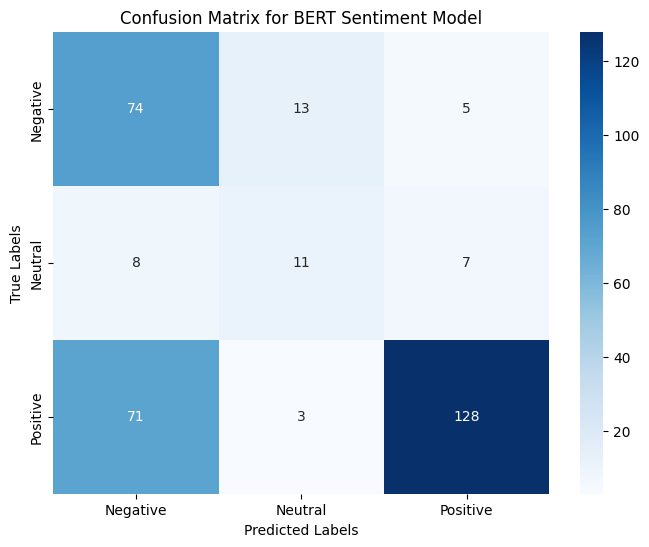

In [ ]:
# Ensure model is in evaluation mode
model.eval()

# Run model on test set
with torch.no_grad():
    outputs = model(X_test.to(device))  # Forward pass
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    y_pred = torch.argmax(probabilities, dim=1).cpu().numpy()  # Convert to NumPy

# Now you can generate the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ["Negative", "Neutral", "Positive"]

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for BERT Sentiment Model")
plt.show()

In [ ]:
# Ensure y_pred is a pandas Series
sentiment_counts = pd.Series(y_pred).value_counts().sort_index()

# Map sentiment labels based on unique values in y_pred
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
sentiment_df = pd.DataFrame({"Sentiment": sentiment_counts.index.map(sentiment_labels), "Count": sentiment_counts.values})

# Color Mapping: Negative - Red, Neutral - Blue, Positive - Green
colors = {"Negative": "red", "Neutral": "blue", "Positive": "green"}

# Plot
fig = px.bar(sentiment_df, x="Sentiment", y="Count", title="Sentiment Distribution (BERT Model)", color="Sentiment",
             color_discrete_map=colors)

fig.show()

In [ ]:
print(df.columns)

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight', 'sentiment_label', 'sentiment'],
      dtype='object')


In [ ]:
df_test = df.iloc[:len(y_pred)].copy()  # Create a subset of df for test data
df_test["sentiment"] = y_pred

print("df shape:", df_test.shape)
print("y_pred length:", len(y_pred))

df shape: (320, 29)
y_pred length: 320


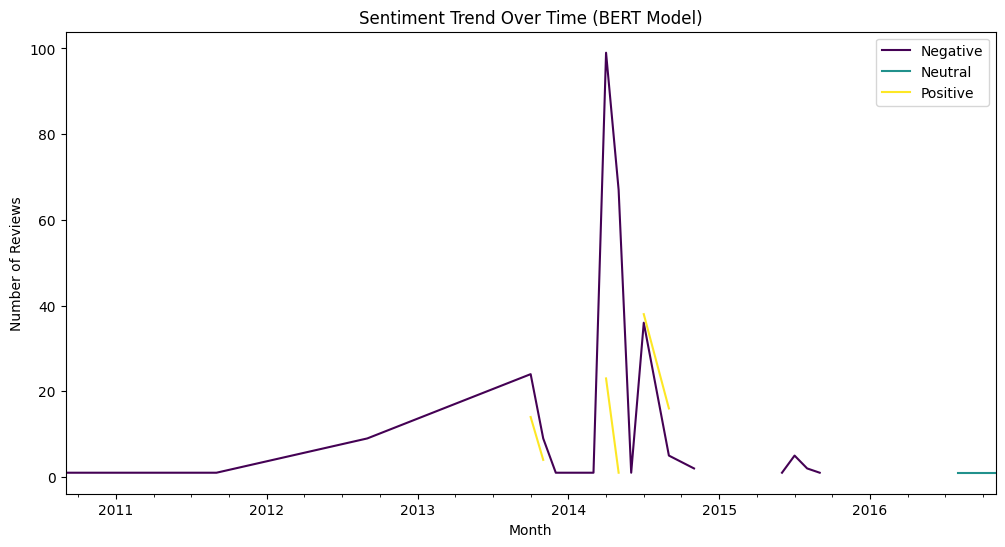

In [ ]:
# Assuming you have a column `date` in `df` that represents time
df["date"] = pd.to_datetime(df["reviews.date"], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")

df_test["sentiment"] = y_pred  # Replace with new predictions

# Group by time to visualize sentiment trends
sentiment_over_time = df.groupby(df["date"].dt.to_period("M"))["sentiment"].value_counts().unstack()

# Plot
sentiment_over_time.plot(kind="line", figsize=(12, 6), colormap="viridis")
plt.title("Sentiment Trend Over Time (BERT Model)")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.legend(["Negative", "Neutral", "Positive"])
plt.show()

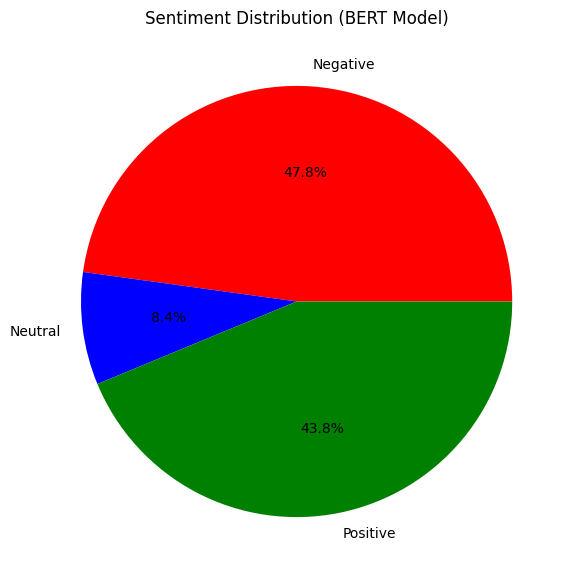

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts, labels=["Negative", "Neutral", "Positive"], autopct='%1.1f%%', colors=["red", "blue", "green"])
plt.title("Sentiment Distribution (BERT Model)")
plt.show()